In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
learning_rate = 0.001
num_epochs = 15

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

full_dataset = torchvision.datasets.EuroSAT(
    root='./data', 
    download=True,
    transform=transform_train
)

100%|██████████| 94.3M/94.3M [00:19<00:00, 4.93MB/s]


In [3]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class SatelliteCNN(nn.Module):
    def __init__(self):
        super(SatelliteCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((4, 4))
            
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [4]:
model = SatelliteCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

best_accuracy = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    scheduler.step(train_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | '
          f'Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/15] | Train Loss: 0.9860 | Train Acc: 66.38% | Val Acc: 73.35%
Epoch [2/15] | Train Loss: 0.6054 | Train Acc: 80.29% | Val Acc: 80.48%
Epoch [3/15] | Train Loss: 0.4678 | Train Acc: 85.25% | Val Acc: 86.81%
Epoch [4/15] | Train Loss: 0.3829 | Train Acc: 88.18% | Val Acc: 79.46%
Epoch [5/15] | Train Loss: 0.3504 | Train Acc: 89.26% | Val Acc: 90.28%
Epoch [6/15] | Train Loss: 0.2861 | Train Acc: 91.15% | Val Acc: 93.15%
Epoch [7/15] | Train Loss: 0.2405 | Train Acc: 92.62% | Val Acc: 92.04%
Epoch [8/15] | Train Loss: 0.2269 | Train Acc: 92.88% | Val Acc: 91.24%
Epoch [9/15] | Train Loss: 0.2020 | Train Acc: 93.91% | Val Acc: 90.26%
Epoch [10/15] | Train Loss: 0.2027 | Train Acc: 93.95% | Val Acc: 94.81%
Epoch [11/15] | Train Loss: 0.1715 | Train Acc: 94.76% | Val Acc: 93.15%
Epoch [12/15] | Train Loss: 0.1758 | Train Acc: 94.62% | Val Acc: 85.13%
Epoch [13/15] | Train Loss: 0.1531 | Train Acc: 95.30% | Val Acc: 94.98%
Epoch [14/15] | Train Loss: 0.1346 | Train Acc: 95.98% | Val

In [5]:
print(f'\nBest Validation Accuracy: {best_accuracy:.2f}%')


Best Validation Accuracy: 94.98%


In [6]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
               'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
               'River', 'SeaLake')

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9481    0.9481    0.9481       578
              Forest     0.9950    0.9631    0.9788       623
HerbaceousVegetation     0.9252    0.8177    0.8682       620
             Highway     0.9662    0.9681    0.9672       502
          Industrial     0.9744    0.9880    0.9812       501
             Pasture     0.9406    0.9496    0.9451       417
       PermanentCrop     0.8221    0.9390    0.8767       492
         Residential     0.9932    0.9881    0.9906       589
               River     0.9724    0.9522    0.9622       481
             SeaLake     0.9597    0.9966    0.9778       597

            accuracy                         0.9498      5400
           macro avg     0.9497    0.9511    0.9496      5400
        weighted avg     0.9513    0.9498    0.9497      5400



In [7]:
print('\nConfusion Matrix:')
print(confusion_matrix(all_labels, all_preds))


Confusion Matrix:
[[548   1   0   0   0   6   6   0   2  15]
 [  0 600  12   0   0   8   0   0   0   3]
 [  8   0 507   1   0   6  91   3   1   3]
 [  1   1   4 486   2   0   0   0   8   0]
 [  0   0   0   4 495   0   1   0   1   0]
 [  3   0  14   2   0 396   1   0   0   1]
 [ 11   0   7   3   5   3 462   1   0   0]
 [  0   0   0   1   6   0   0 582   0   0]
 [  7   1   4   6   0   1   1   0 458   3]
 [  0   0   0   0   0   1   0   0   1 595]]


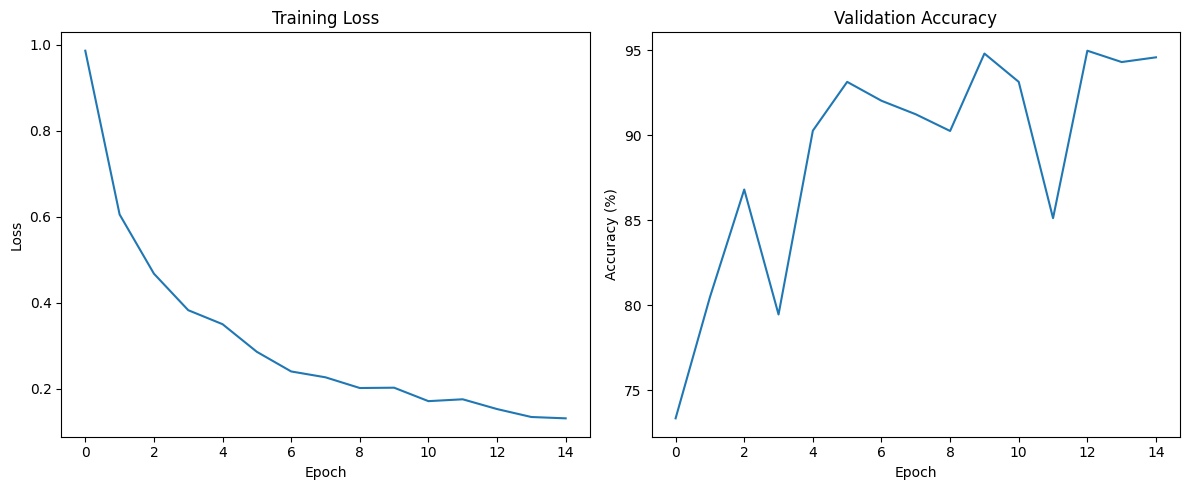

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()